# **1.- Data preparation COVID-19 Oxford Stringency Index and Johns Hopkins Time Series** #

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_c = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/JHU_confirmed_may_15.csv',encoding="ISO-8859-1")
df_d = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/JHU_deaths_may_15.csv',encoding="ISO-8859-1")
df_r = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/JHU_recovered_may_15.csv',encoding="ISO-8859-1")
df_gover = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/Oxford_dataset_may_15.csv',encoding="ISO-8859-1")

In [4]:
#Get time series of cases confirmed
df_cm = df_c.melt(id_vars=["Province/State", "Country/Region","Lat","Long"], 
        var_name="Date", 
        value_name="Confirmed")

df_cm['Date'] = pd.to_datetime(df_cm['Date'])
df_con = df_cm.groupby(['Country/Region','Date'])['Confirmed'].sum().reset_index()

In [5]:
#Get time series of cases death
df_dm = df_d.melt(id_vars=["Province/State", "Country/Region","Lat","Long"], 
        var_name="Date", 
        value_name="Deaths")

df_dm['Date'] = pd.to_datetime(df_dm['Date'])
df_dea = df_dm.groupby(['Country/Region','Date'])['Deaths'].sum().reset_index()

In [6]:
#Get time series of cases recovered
df_rm = df_r.melt(id_vars=["Province/State", "Country/Region","Lat","Long"], 
        var_name="Date", 
        value_name="Recovered")

df_rm['Date'] = pd.to_datetime(df_rm['Date'])
df_rec = df_rm.groupby(['Country/Region','Date'])['Recovered'].sum().reset_index()

In [7]:
#putting all of them together
df_complete = df_con.copy()
df_complete['Deaths'] = df_dea['Deaths']
df_complete['Recovered'] = df_rec['Recovered']
df_complete = df_complete[['Date','Country/Region','Confirmed','Deaths','Recovered']]
df_complete.head()

,Date,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Afghanistan,0,0,0
1,2020-01-23,Afghanistan,0,0,0
2,2020-01-24,Afghanistan,0,0,0
3,2020-01-25,Afghanistan,0,0,0
4,2020-01-26,Afghanistan,0,0,0


In [8]:
#Testing
df_con[df_con['Country/Region'] == 'Korea, South'].tail(2)

,Country/Region,Date,Confirmed
10486,"Korea, South",2020-05-13,10991
10487,"Korea, South",2020-05-14,11018


In [9]:
#Changing time and removing unuseful columns
df_gover['Date'] = pd.to_datetime(df_gover['Date'], format='%Y%m%d', errors='coerce') 
df_gov = df_gover[['CountryName','CountryCode','Date','StringencyIndexForDisplay']]
df_gov = df_gov.rename(columns={"CountryName": "Country/Region"})
df_gov = df_gov.fillna(0)
df_gov.head()

,Country/Region,CountryCode,Date,StringencyIndexForDisplay
0,Aruba,ABW,2020-01-01,0.0
1,Aruba,ABW,2020-01-02,0.0
2,Aruba,ABW,2020-01-03,0.0
3,Aruba,ABW,2020-01-04,0.0
4,Aruba,ABW,2020-01-05,0.0


In [11]:
#len(df_gov[df_gov['Country/Region'] == 'Mexico'].index)
#Function to update the values of 
def update(val):
    if val == 'Czechia':
        return 'Czech Republic'
    elif val == 'Korea, South':
        return 'South Korea'
    elif val == 'Kyrgyzstan':
        return 'Kyrgyz Republic'
    elif val == 'US':
        return 'United States'
    elif val == 'Slovakia':
        return 'Slovak Republic'
    elif val == 'Taiwan*':
        return 'Taiwan'    
    else:
        return str(val)

In [12]:
#Updating the values names to be the same between datasets
names = df_complete['Country/Region'].apply(lambda x: update(x))

#Dropping the unuseful columns
df_complete = df_complete.drop(['Country/Region'], axis = 1 )

#Inserting the values in the df
df_complete.insert(1,'Country/Region',names.values)

In [13]:
#Merging John Hopkins and Oxford Datasets
df_final= pd.merge(df_complete,
                  df_gov,
                  on = ['Country/Region','Date'],
                  how = 'left')

In [14]:
#Final changes on the dataset
df_final = df_final.drop('CountryCode', axis = 1)
df_final['StringencyIndexForDisplay'] = df_final['StringencyIndexForDisplay'].fillna(0)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21432 entries, 0 to 21431
Data columns (total 6 columns):
Date                         21432 non-null datetime64[ns]
Country/Region               21432 non-null object
Confirmed                    21432 non-null int64
Deaths                       21432 non-null int64
Recovered                    21432 non-null int64
StringencyIndexForDisplay    21432 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.1+ MB


In [15]:
#Create column with new cases
list_countries = df_final['Country/Region'].unique()
countries = df_final.groupby('Country/Region')
list_df = list()
#list_countries = ['China','Singapore','South Korea','United States','Italy','Spain','Mexico']

for elem in list_countries:
    new_cases = list()
    country = countries.get_group(elem)
    confirmed = country['Confirmed'].tolist()

    for i in range(len(confirmed)):
        if i ==0:
            new_cases.append(confirmed[0])
        else:
            val = confirmed[i] - confirmed[i-1]
            new_cases.append(val)

    #Inserting the values in the df
    country.insert(2,'New Cases',new_cases)
    #append df
    list_df.append(country)

files = pd.concat(list_df, axis=0, ignore_index=True)
files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21432 entries, 0 to 21431
Data columns (total 7 columns):
Date                         21432 non-null datetime64[ns]
Country/Region               21432 non-null object
New Cases                    21432 non-null int64
Confirmed                    21432 non-null int64
Deaths                       21432 non-null int64
Recovered                    21432 non-null int64
StringencyIndexForDisplay    21432 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 1.1+ MB


In [17]:
#Final NEW Cases in study!!!
files = files.rename(columns={"StringencyIndexForDisplay": "StringencyIndex"})
files.to_csv("C:/Users/Milara/Desktop/HW5_ML/dataset_FE_v1.csv", encoding="ISO-8859-1", index = False) #thus it is necessary to save it as the usual type of coding

# **2.- Getting the countries that have surpressed their curve of new cases** #


In [16]:
#Read the dataset JHU + Oxford 
df = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/dataset_FE_v1.csv',encoding="ISO-8859-1")

#Read the list of countries which have a flatten incidence curve
countries_surpressed = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/List_Countries_curves_surpressed.csv',encoding="ISO-8859-1")
list_surpressed = countries_surpressed['Countries'].tolist()

In [17]:
#Append the countries with new cases curve surpressed and Mexico
countries = df.groupby('Country/Region')
list_df = list()

for elem in list_surpressed:
    country = countries.get_group(elem)
    list_df.append(country)

files5 = pd.concat(list_df, axis=0, ignore_index=True)

In [20]:
files5.to_csv("C:/Users/Milara/Desktop/HW5_ML/dataset_surpressed_curves_may15th_v1.csv", encoding="ISO-8859-1", index = False) #thus it is necessary to save it as the usual type of coding

# **3.- Add the population to each country** #

In [18]:
df_reduced = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/dataset_surpressed_curves_may15th_v1.csv',encoding="ISO-8859-1")
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5244 entries, 0 to 5243
Data columns (total 7 columns):
Date               5244 non-null object
Country/Region     5244 non-null object
New Cases          5244 non-null int64
Confirmed          5244 non-null int64
Deaths             5244 non-null int64
Recovered          5244 non-null int64
StringencyIndex    5244 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 286.9+ KB


In [19]:
df_reduced = df_reduced.rename(columns={"Country/Region": "Country"})
df_reduced.Country.unique()

array(['China', 'France', 'Germany', 'Italy', 'Spain', 'Belgium',
       'Austria', 'Ireland', 'Israel', 'Japan', 'Netherlands', 'Portugal',
       'Switzerland', 'South Korea', 'Australia', 'Czech Republic',
       'Denmark', 'Norway', 'Serbia', 'Djibouti', 'Estonia', 'Greece',
       'Hungary', 'Luxembourg', 'Malaysia', 'Thailand', 'Croatia', 'Cuba',
       'Iceland', 'Lithuania', 'New Zealand', 'Niger', 'North Macedonia',
       'Slovak Republic', 'Slovenia', 'Tunisia', 'Andorra', 'Costa Rica',
       'Cyprus', 'Latvia', 'Malta', 'Mauritius', 'West Bank and Gaza',
       'Brunei', 'Montenegro', 'Taiwan'], dtype=object)

In [20]:
#Check countries that don't have any stringency index
test = df_reduced.groupby('Country')['StringencyIndex'].sum().sort_values()
test.head(10)

Country
West Bank and Gaza       0.00
North Macedonia          0.00
Montenegro               0.00
Malta                    0.00
Lithuania                0.00
Latvia                   0.00
Taiwan                3075.46
Andorra               3344.98
Niger                 3420.32
Iceland               3945.85
Name: StringencyIndex, dtype: float64

In [21]:
#Removing countries with no strigency Index
countries = ['West Bank and Gaza','North Macedonia','Montenegro','Malta','Lithuania','Latvia']

for elem in countries:
    indexNames = df_reduced[ df_reduced['Country'] == elem ].index
    df_reduced.drop(indexNames , inplace=True)
    
test = df_reduced.groupby('Country')['StringencyIndex'].sum().sort_values()
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4560 entries, 0 to 5243
Data columns (total 7 columns):
Date               4560 non-null object
Country            4560 non-null object
New Cases          4560 non-null int64
Confirmed          4560 non-null int64
Deaths             4560 non-null int64
Recovered          4560 non-null int64
StringencyIndex    4560 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 285.0+ KB


In [22]:
#Reading the population of all the countries in the world in 2019
df_pop = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/SYB62_1_201907_Population, Surface Area and Density.csv',encoding="ISO-8859-1")
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7351 entries, 0 to 7350
Data columns (total 7 columns):
Region/Country/Area    7351 non-null int64
Country                7351 non-null object
Year                   7351 non-null int64
Series                 7351 non-null object
Value                  7351 non-null float64
Footnotes              978 non-null object
Source                 7351 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 402.1+ KB


In [23]:
df_filter = df_pop[ (df_pop['Year'] == 2019) & (df_pop['Series'] == 'Population mid-year estimates (millions)') ]
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 22 to 7344
Data columns (total 7 columns):
Region/Country/Area    266 non-null int64
Country                266 non-null object
Year                   266 non-null int64
Series                 266 non-null object
Value                  266 non-null float64
Footnotes              22 non-null object
Source                 266 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 16.6+ KB


In [24]:
#Rename Countries
#Function to update the values of 
def update(val):
    if val == 'Czechia':
        return 'Czech Republic'
    elif val == 'Republic of Korea':
        return 'South Korea'
    elif val == 'Brunei Darussalam':
        return 'Brunei'
    elif val == 'Slovakia':
        return 'Slovak Republic'
    else:
        return str(val)
    
#NOTE: TAIWAN BELONG TO CHINA, THEREFORE I´ll copy the value from wikipedia

In [25]:
#Updating the values names to be the same between datasets
names = df_filter['Country'].apply(lambda x: update(x))

#Dropping the unuseful columns
df_filter = df_filter.drop(['Country'], axis = 1 )

#Inserting the values in the df
df_filter.insert(1,'Country',names.values)

In [26]:
#Merging datasets 
df_res= pd.merge(df_reduced,
                  df_filter[['Country','Value']],
                  on = ['Country'],
                  how = 'left')
df_res = df_res.rename(columns={"Value": "Population (Millions)"})
df_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4560 entries, 0 to 4559
Data columns (total 8 columns):
Date                     4560 non-null object
Country                  4560 non-null object
New Cases                4560 non-null int64
Confirmed                4560 non-null int64
Deaths                   4560 non-null int64
Recovered                4560 non-null int64
StringencyIndex          4560 non-null float64
Population (Millions)    4446 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 320.6+ KB


In [27]:
#Check countries that don't have any value of population
test = df_res.groupby('Country')['Population (Millions)'].sum().sort_values()
test.head(10)

Country
Taiwan          0.0000
Andorra         8.7894
Iceland        38.6460
Brunei         49.3962
Luxembourg     70.1898
Djibouti      110.9904
Cyprus        136.6404
Mauritius     144.7458
Estonia       151.1184
Slovenia      236.9718
Name: Population (Millions), dtype: float64

In [28]:
#Updating Taiwan population manually
index = df_res[ df_res['Country'] == 'Taiwan'].index
df_res.iloc[index,7] = 23.78
df_res[ df_res['Country'] == 'Taiwan'].head()

,Date,Country,New Cases,Confirmed,Deaths,Recovered,StringencyIndex,Population (Millions)
4446,2020-01-22,Taiwan,1,1,0,0,11.11,23.78
4447,2020-01-23,Taiwan,0,1,0,0,19.44,23.78
4448,2020-01-24,Taiwan,2,3,0,0,19.44,23.78
4449,2020-01-25,Taiwan,0,3,0,0,19.44,23.78
4450,2020-01-26,Taiwan,1,4,0,0,19.44,23.78


In [29]:
df_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4560 entries, 0 to 4559
Data columns (total 8 columns):
Date                     4560 non-null object
Country                  4560 non-null object
New Cases                4560 non-null int64
Confirmed                4560 non-null int64
Deaths                   4560 non-null int64
Recovered                4560 non-null int64
StringencyIndex          4560 non-null float64
Population (Millions)    4560 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 320.6+ KB


In [38]:
#Final Maxstringency with China
df_res.to_csv("C:/Users/Milara/Desktop/HW5_ML/dataset_surpressed_population_may15th_v1.csv", encoding="ISO-8859-1", index = False) #thus it is necessary to save it as the usual type of coding

# **4.- Remove Negative values from New Cases** #

In [32]:
df = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/dataset_surpressed_population_may15th_v1.csv',encoding="ISO-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 8 columns):
Date                     4560 non-null object
Country                  4560 non-null object
New Cases                4560 non-null int64
Confirmed                4560 non-null int64
Deaths                   4560 non-null int64
Recovered                4560 non-null int64
StringencyIndex          4560 non-null float64
Population (Millions)    4560 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 285.1+ KB


In [33]:
#If valuew of new cases is negative then keep the previous one
list_countries = df['Country'].unique()
countries = df.groupby('Country')
list_df = list()

for elem in list_countries:
    new_cases = list()
    country = countries.get_group(elem)
    confirmed = country['Confirmed'].tolist()

    for i in range(len(confirmed)):
        if i ==0:
            new_cases.append(confirmed[0])
        elif ((confirmed[i] - confirmed[i-1]) > -1 ):
            val = confirmed[i] - confirmed[i-1]
            new_cases.append(val)
        else:
            val = confirmed[i-1] - confirmed[i-2]
            new_cases.append(val)

    #Inserting the values in the df
    country.insert(2,'New_Cases_noNeg',new_cases)
    #append df
    list_df.append(country)

files = pd.concat(list_df, axis=0, ignore_index=True)
files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 9 columns):
Date                     4560 non-null object
Country                  4560 non-null object
New_Cases_noNeg          4560 non-null int64
New Cases                4560 non-null int64
Confirmed                4560 non-null int64
Deaths                   4560 non-null int64
Recovered                4560 non-null int64
StringencyIndex          4560 non-null float64
Population (Millions)    4560 non-null float64
dtypes: float64(2), int64(5), object(2)
memory usage: 320.7+ KB


In [34]:
#Final Maxstringency with China
files.to_csv("C:/Users/Milara/Desktop/HW5_ML/dataset_surpressed_noNeg_may15th_v1.csv", encoding="ISO-8859-1", index = False) #thus it is necessary to save it as the usual type of coding

# **5.- Normalize the data set based on population** #

In [35]:
df = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/dataset_surpressed_noNeg_may15th_v1.csv',encoding="ISO-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 9 columns):
Date                     4560 non-null object
Country                  4560 non-null object
New_Cases_noNeg          4560 non-null int64
New Cases                4560 non-null int64
Confirmed                4560 non-null int64
Deaths                   4560 non-null int64
Recovered                4560 non-null int64
StringencyIndex          4560 non-null float64
Population (Millions)    4560 non-null float64
dtypes: float64(2), int64(5), object(2)
memory usage: 320.7+ KB


In [36]:
#Normalizing per millions
lista = ['New Cases','Confirmed','Deaths','Recovered','New_Cases_noNeg']
df_norm = df.copy()

for elem in lista:
    df_norm[elem + "_norm"] = df_norm[elem]/df_norm['Population (Millions)']
    
df_norm.head()  

,Date,Country,New_Cases_noNeg,New Cases,Confirmed,Deaths,Recovered,StringencyIndex,Population (Millions),New Cases_norm,Confirmed_norm,Deaths_norm,Recovered_norm,New_Cases_noNeg_norm
0,2020-01-22,China,548,548,548,17,28,23.82,1433.7837,0.382205,0.382205,0.011857,0.019529,0.382205
1,2020-01-23,China,95,95,643,18,30,42.35,1433.7837,0.066258,0.448464,0.012554,0.020924,0.066258
2,2020-01-24,China,277,277,920,26,36,42.35,1433.7837,0.193195,0.641659,0.018134,0.025108,0.193195
3,2020-01-25,China,486,486,1406,42,39,45.52,1433.7837,0.338963,0.980622,0.029293,0.027201,0.338963
4,2020-01-26,China,669,669,2075,56,49,67.74,1433.7837,0.466598,1.447220,0.039057,0.034175,0.466598


In [45]:
#Final Maxstringency with China
df_norm.to_csv("C:/Users/Milara/Desktop/HW5_ML/dataset_surpressed_norm_may15th_v1.csv", encoding="ISO-8859-1", index = False) #thus it is necessary to save it as the usual type of coding

# **6.- Create count since the 15th case over a million of people (using Confirmed_normed)** #

In [37]:
df = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/dataset_surpressed_norm_may15th_v1.csv',encoding="ISO-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 14 columns):
Date                     4560 non-null object
Country                  4560 non-null object
New_Cases_noNeg          4560 non-null int64
New Cases                4560 non-null int64
Confirmed                4560 non-null int64
Deaths                   4560 non-null int64
Recovered                4560 non-null int64
StringencyIndex          4560 non-null float64
Population (Millions)    4560 non-null float64
New Cases_norm           4560 non-null float64
Confirmed_norm           4560 non-null float64
Deaths_norm              4560 non-null float64
Recovered_norm           4560 non-null float64
New_Cases_noNeg_norm     4560 non-null float64
dtypes: float64(7), int64(5), object(2)
memory usage: 498.8+ KB


In [38]:
#Create column with count after the first case
list_countries = df['Country'].unique()
countries = df.groupby('Country')
list_df = list()

for elem in list_countries:
    count = 1
    days = list()
    country = countries.get_group(elem)
    confirmed = country['Confirmed_norm'].tolist()

    for i in range(len(confirmed)):
        if (confirmed[i] > 15) and (count == 1):
            days.append(count)
            count +=1
        elif (count == 1):
            days.append(0)
        elif (count > 1):
            days.append(count)
            count +=1

    #Inserting the values in the df
    country.insert(1,'Days',days)
    #append df
    list_df.append(country)

files = pd.concat(list_df, axis=0, ignore_index=True)
files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 15 columns):
Date                     4560 non-null object
Days                     4560 non-null int64
Country                  4560 non-null object
New_Cases_noNeg          4560 non-null int64
New Cases                4560 non-null int64
Confirmed                4560 non-null int64
Deaths                   4560 non-null int64
Recovered                4560 non-null int64
StringencyIndex          4560 non-null float64
Population (Millions)    4560 non-null float64
New Cases_norm           4560 non-null float64
Confirmed_norm           4560 non-null float64
Deaths_norm              4560 non-null float64
Recovered_norm           4560 non-null float64
New_Cases_noNeg_norm     4560 non-null float64
dtypes: float64(7), int64(6), object(2)
memory usage: 534.5+ KB


In [48]:
#Final Maxstringency with China
files.to_csv("C:/Users/Milara/Desktop/HW5_ML/dataset_surpressed_norm_days_may15th_v1.csv", encoding="ISO-8859-1", index = False) #thus it is necessary to save it as the usual type of coding

# **7.- Generate the Mean and Standard Deviation of each curve (days vs New_cases_noNeg_norm)** #

In [39]:
df = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/dataset_surpressed_norm_days_may15th_v1.csv',encoding="ISO-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 15 columns):
Date                     4560 non-null object
Days                     4560 non-null int64
Country                  4560 non-null object
New_Cases_noNeg          4560 non-null int64
New Cases                4560 non-null int64
Confirmed                4560 non-null int64
Deaths                   4560 non-null int64
Recovered                4560 non-null int64
StringencyIndex          4560 non-null float64
Population (Millions)    4560 non-null float64
New Cases_norm           4560 non-null float64
Confirmed_norm           4560 non-null float64
Deaths_norm              4560 non-null float64
Recovered_norm           4560 non-null float64
New_Cases_noNeg_norm     4560 non-null float64
dtypes: float64(7), int64(6), object(2)
memory usage: 534.5+ KB


In [40]:
#Transforming the cases to days repetitions to be able to compute the mean and std
#NOTE!! THE SCALATION of x10 TO AVOID HAVING 0.5,  IN THIS SENSE MOST OF THE VALUES ARE NOT MISSED

df_hist = df[df['Days'] > 0]
list_countries = df_hist['Country'].unique()
countries = df_hist.groupby('Country')
full_hist = list()

for elem in list_countries:
    days_hist = np.full(1,9999)
    country = countries.get_group(elem)
    days = country['Days'].tolist()
    cases = np.round(country['New_Cases_noNeg_norm']*10,0).tolist()

    for i in range(len(days)):
        a = np.full((int(cases[i])),days[i])
        days_hist = np.append(days_hist,a)

    #append df
    full_hist.append(days_hist)


In [41]:
#Getting the mean and std of time
mean_countries = []
std_countries = []

for i in range( len(list_countries)):
    cases = pd.DataFrame(full_hist[i])
    indexes = cases[cases[0] == 9999].index
    cases.drop(indexes, inplace = True)
    
    mean_countries.append(cases[0].mean())
    std_countries.append(cases[0].std())


In [42]:
#Create df with mean and std of the time that took to drop the curve assuming is normal
df_data = pd.DataFrame(mean_countries,columns = ['Mean'])

#Inserting the values in the df
df_data.insert(0,'Countries',list_countries)

#Inserting the values in the df
df_data.insert(2,'Std',std_countries)

df_data.head()

,Countries,Mean,Std
0,China,11.639013,12.004950
1,France,33.615337,13.234885
2,Germany,27.631084,13.888391
3,Italy,36.082234,16.587074
4,Spain,29.596212,13.975643


In [43]:
#getting the max cases of each country ->normalized per million of people
max_cases = []
countries = df_hist.groupby('Country')

for elem in list_countries:
    country = countries.get_group(elem)
    max_cases.append(country['New_Cases_noNeg_norm'].max())

In [44]:
#Inserting the values in the df
df_data.insert(3,'Max',max_cases)

df_data.head()

,Countries,Mean,Std,Max
0,China,11.639013,12.004950,10.556683
1,France,33.615337,13.234885,412.238963
2,Germany,27.631084,13.888391,83.013039
3,Italy,36.082234,16.587074,108.290490
4,Spain,29.596212,13.975643,206.047483


In [55]:
#Saving the file
df_data.to_csv("C:/Users/Milara/Desktop/HW5_ML/dataset_mean_std_max_may15th_v1.csv", encoding="ISO-8859-1", index = False) #thus it is necessary to save it as the usual type of coding

# **8.- Exploratory Data Analysis** #

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
df_explo  = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/dataset_surpressed_norm_days_may15th_v1.csv',encoding="ISO-8859-1")
df_explo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4560 entries, 0 to 4559
Data columns (total 15 columns):
Date                     4560 non-null object
Days                     4560 non-null int64
Country                  4560 non-null object
New_Cases_noNeg          4560 non-null int64
New Cases                4560 non-null int64
Confirmed                4560 non-null int64
Deaths                   4560 non-null int64
Recovered                4560 non-null int64
StringencyIndex          4560 non-null float64
Population (Millions)    4560 non-null float64
New Cases_norm           4560 non-null float64
Confirmed_norm           4560 non-null float64
Deaths_norm              4560 non-null float64
Recovered_norm           4560 non-null float64
New_Cases_noNeg_norm     4560 non-null float64
dtypes: float64(7), int64(6), object(2)
memory usage: 534.5+ KB


In [4]:
df_kmeans = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/dataset_mean_std_max_may15th_v1.csv',encoding="ISO-8859-1")
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
Countries    40 non-null object
Mean         40 non-null float64
Std          40 non-null float64
Max          40 non-null float64
dtypes: float64(3), object(1)
memory usage: 1.3+ KB


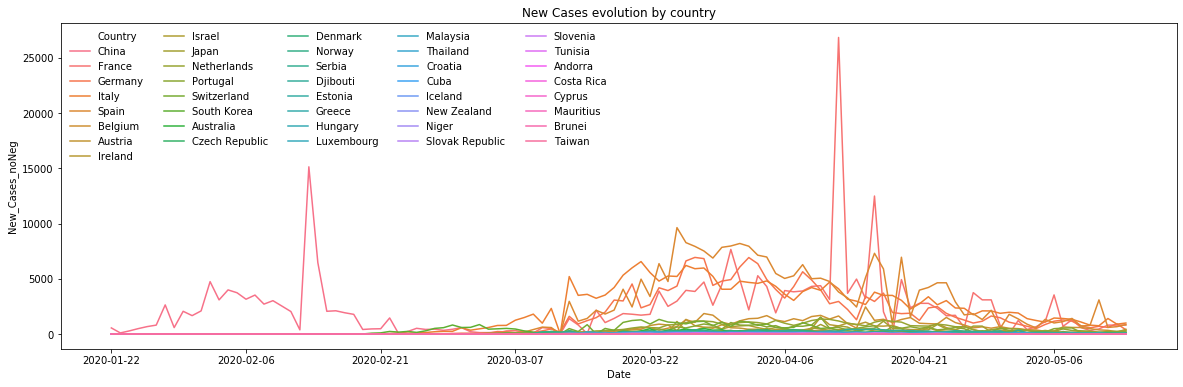

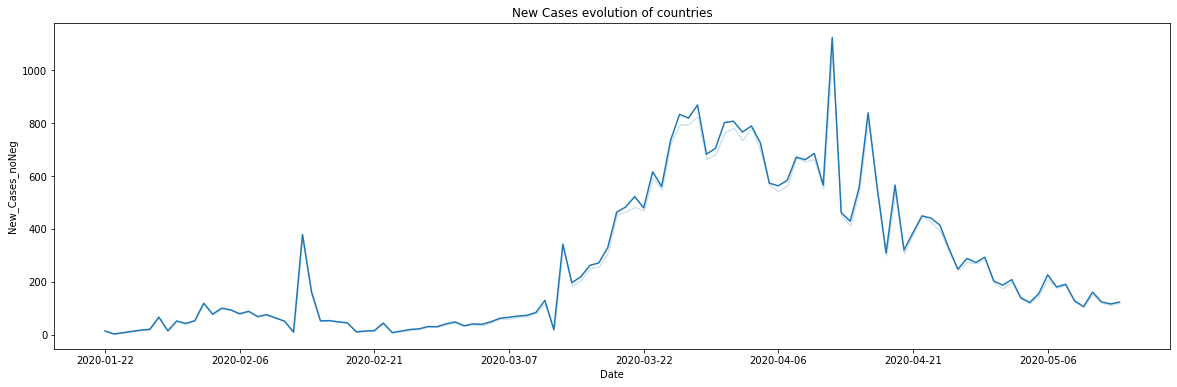

In [18]:
#Figure, Countries with flattened curves

fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
g = sns.lineplot( x = 'Date', hue = 'Country', y = 'New_Cases_noNeg', data = df_explo )
g.set_title( 'New Cases evolution by country' )
plt.setp(ax,xticks=[0,15,30,45,60,75,90,105])
ax.legend(frameon=False, loc='upper left', ncol=5)

fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
g = sns.lineplot( x = 'Date', y = 'New_Cases_noNeg', data = df_explo, ci = False )
g.set_title( 'New Cases evolution of countries' )
plt.setp(ax,xticks=[0,15,30,45,60,75,90,105])


pass

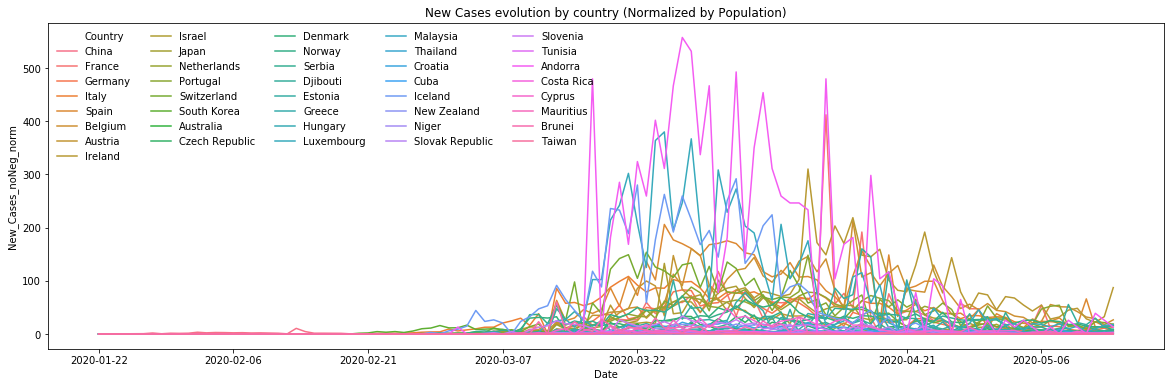

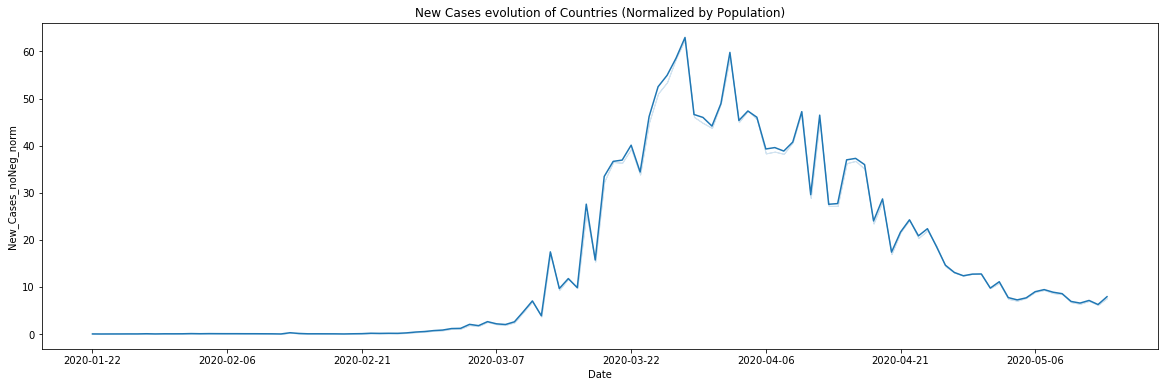

In [31]:
#Figure, flattened curves normalized
fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
g = sns.lineplot( x = 'Date', hue = 'Country', y = 'New_Cases_noNeg_norm', data = df_explo )
g.set_title( 'New Cases evolution by country (Normalized by Population)' )
plt.setp(ax,xticks=[0,15,30,45,60,75,90,105])
ax.legend(frameon=False, loc='upper left', ncol=5)

fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
g = sns.lineplot( x = 'Date', y = 'New_Cases_noNeg_norm', data = df_explo, ci = False )
g.set_title( 'New Cases evolution of Countries (Normalized by Population)' )
plt.setp(ax,xticks=[0,15,30,45,60,75,90,105])

pass

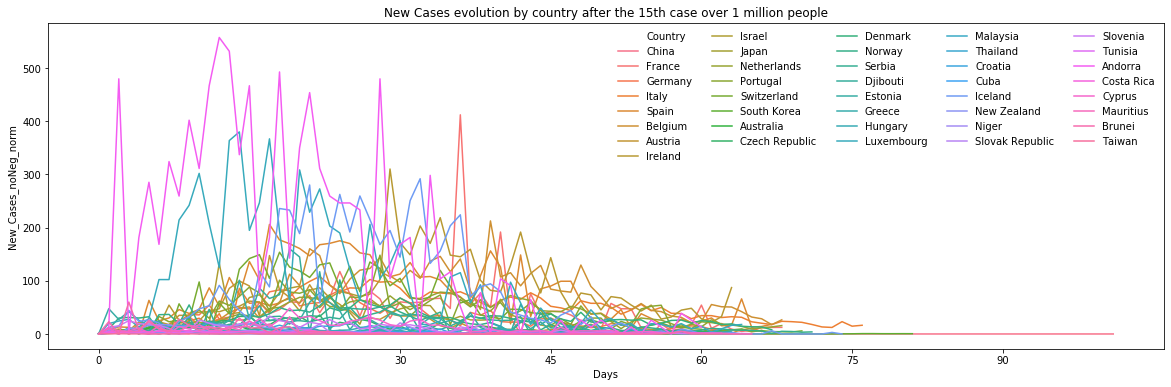

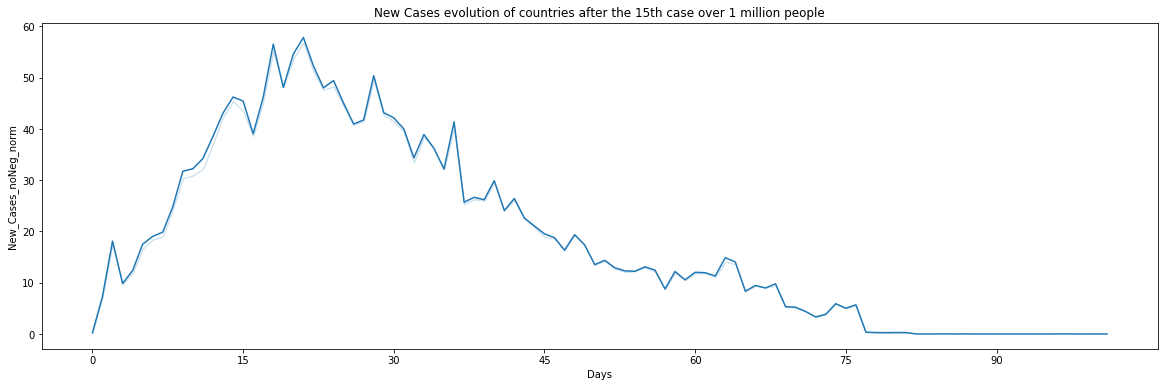

In [23]:
#Figure, Curves normalized after the 15th case over 1 million people

fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
g = sns.lineplot( x = 'Days', hue = 'Country', y = 'New_Cases_noNeg_norm', data = df_explo )
g.set_title( 'New Cases evolution by country after the 15th case over 1 million people' )
plt.setp(ax,xticks=[0,15,30,45,60,75,90])
ax.legend(frameon=False, loc='upper right', ncol=5)

fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
g = sns.lineplot( x = 'Days', y = 'New_Cases_noNeg_norm', data = df_explo , ci= False)
g.set_title( 'New Cases evolution of countries after the 15th case over 1 million people' )
plt.setp(ax,xticks=[0,15,30,45,60,75,90])

pass

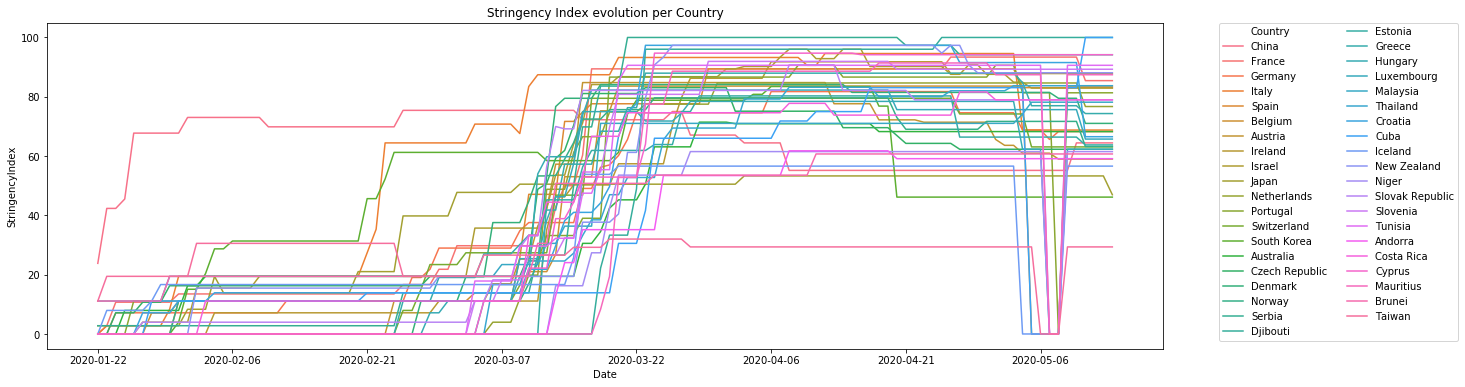

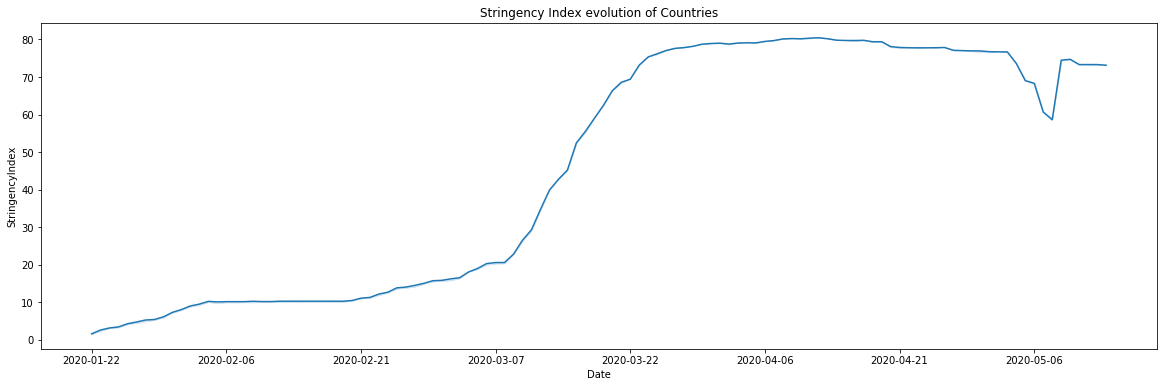

In [24]:
#Figure, Stringency Curves of flatten
fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
g = sns.lineplot( x = 'Date', hue = 'Country', y = 'StringencyIndex', data = df_explo )
g.set_title( 'Stringency Index evolution per Country' )
plt.setp(ax,xticks=[0,15,30,45,60,75,90,105])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 2)

fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
g = sns.lineplot( x = 'Date', y = 'StringencyIndex', data = df_explo, ci = False )
g.set_title( 'Stringency Index evolution of Countries' )
plt.setp(ax,xticks=[0,15,30,45,60,75,90,105])

pass

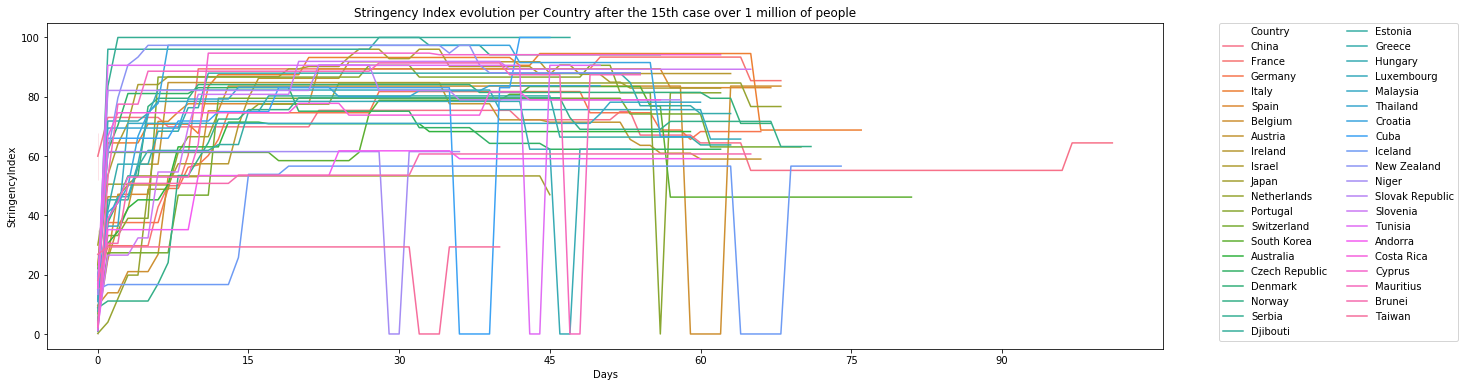

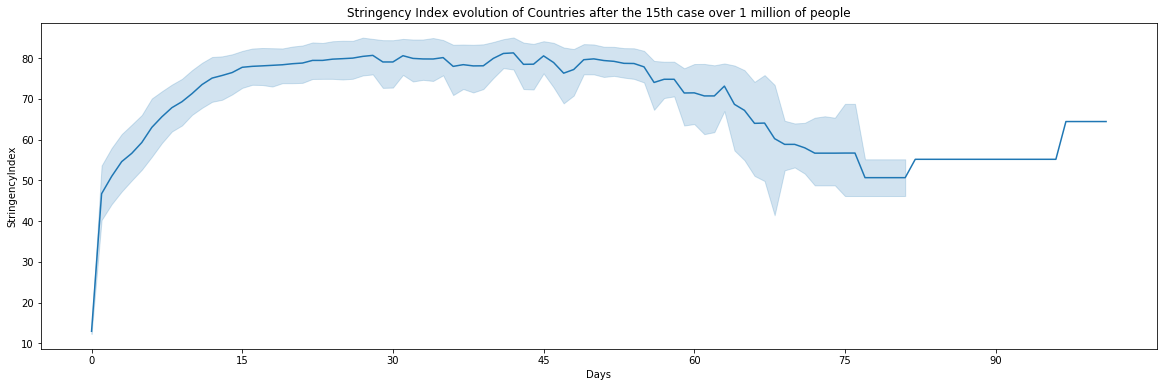

In [16]:
#Figure, Stringency Curves after 15th case over 1 million people

fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
g = sns.lineplot( x = 'Days', hue = 'Country', y = 'StringencyIndex', data = df_explo )
g.set_title( 'Stringency Index evolution per Country after the 15th case over 1 million of people' )
plt.setp(ax,xticks=[0,15,30,45,60,75,90])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 2)

fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
g = sns.lineplot( x = 'Days',  y = 'StringencyIndex', data = df_explo )
g.set_title( 'Stringency Index evolution of Countries after the 15th case over 1 million of people' )
plt.setp(ax,xticks=[0,15,30,45,60,75,90])

pass

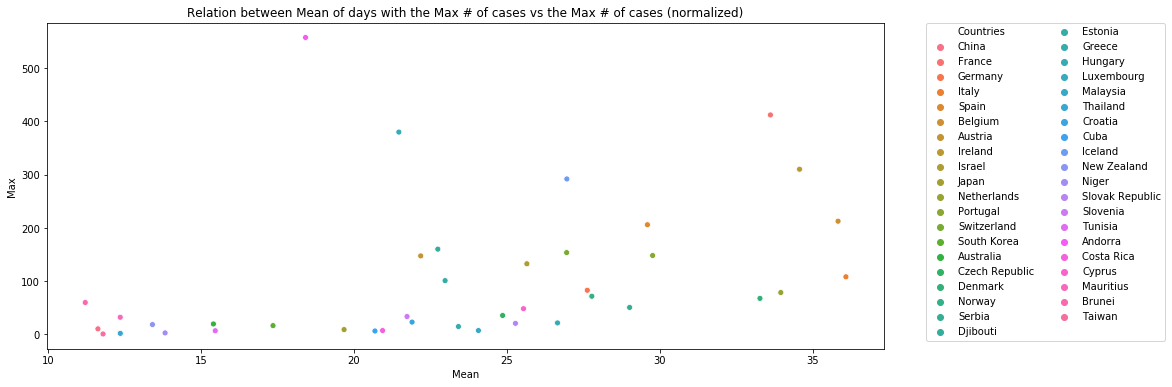

In [15]:
#Figure, Mean vs Max 

fig, ax = plt.subplots( 1, 1, figsize = ( 15, 6 ) )
g = sns.scatterplot( x = 'Mean', hue = 'Countries', y = 'Max', data = df_kmeans )
g.set_title( 'Relation between Mean of days with the Max # of cases vs the Max # of cases (normalized)' )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 2)

pass

# **9.- Modeling with K means** #

In [96]:
import matplotlib.pyplot as plt 
import seaborn as sns

df_kmeans = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/dataset_mean_std_max_may15th_v1.csv',encoding="ISO-8859-1")
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 4 columns):
Countries    40 non-null object
Mean         40 non-null float64
Std          40 non-null float64
Max          40 non-null float64
dtypes: float64(3), object(1)
memory usage: 1.3+ KB


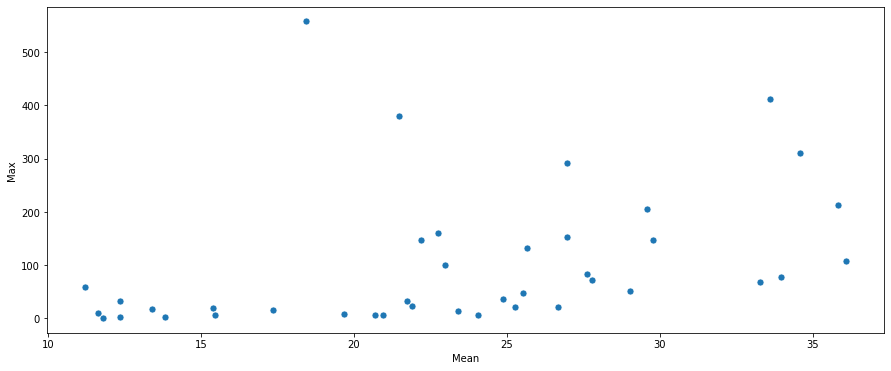

In [98]:
#Scatter Plot 
fig, ax = plt.subplots( 1, 1, figsize = ( 15, 6 ) )
g = sns.scatterplot( x = 'Mean', y = 'Max', data = df_kmeans , s= 50 )

In [99]:
# Elbow method to get the best K
from sklearn.cluster import KMeans
from sklearn import preprocessing


#scaling the data, if one variable has a higher range then the model tends to cluster wrongly
X_train = np.array(df_kmeans[['Max','Mean']].astype(float))
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X_train)

wcss=[]

for i in range(1,11):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

[Text(0, 0.5, 'Variance'), Text(0.5, 0, 'K')]

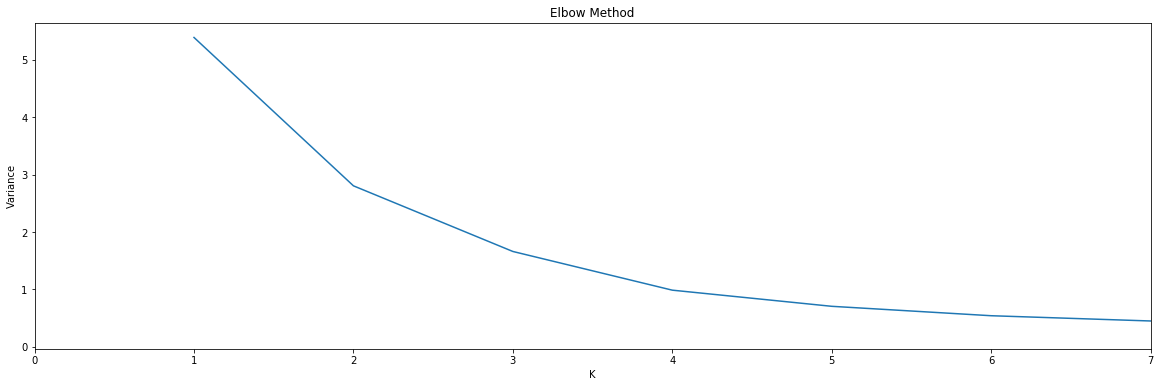

In [100]:
#Graph Elbow method
fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
g = sns.lineplot( x = range(1,11), y = wcss)
g.set_title( 'Elbow Method' )
ax.set(xlim=[0,7])
ax.set(xlabel='K', ylabel='Variance')

In [101]:
#Model Build -> k=4 selected
kmeansmodel = KMeans(n_clusters= 4)
kmeansmodel.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [102]:
#Inserting the values in the df
df_res = df_kmeans.copy()
df_res.insert(4,'Cluster',kmeansmodel.labels_)
df_res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
Countries    40 non-null object
Mean         40 non-null float64
Std          40 non-null float64
Max          40 non-null float64
Cluster      40 non-null int32
dtypes: float64(3), int32(1), object(1)
memory usage: 1.5+ KB


Text(0.5, 1.0, 'K means - Clusters')

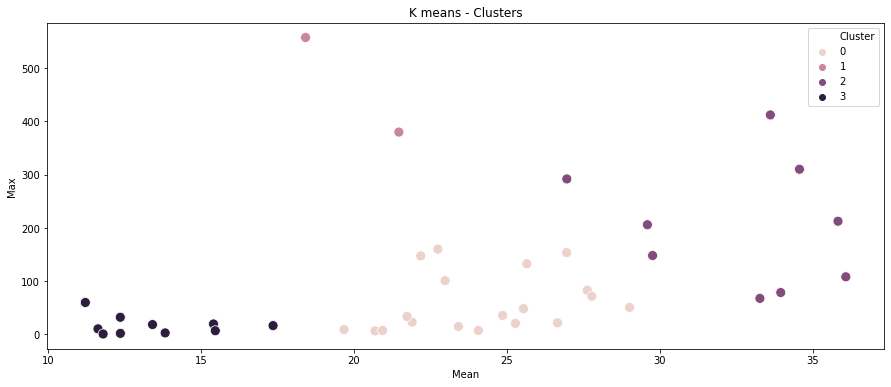

In [105]:
#Plot clusters
fig, ax = plt.subplots( 1, 1, figsize = ( 15, 6 ) )
g = sns.scatterplot( x = 'Mean', hue = 'Cluster', y = 'Max', data = df_res, s= 100 )
g.set_title( 'K means - Clusters' )

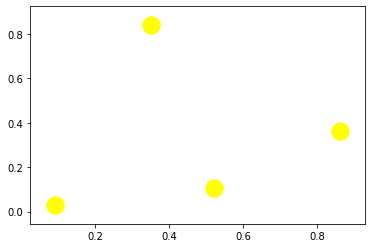

In [85]:
plt.scatter(kmeansmodel.cluster_centers_[:, 1], kmeansmodel.cluster_centers_[:, 0], s = 300, c = 'yellow', label = 'Centroids')
plt.show()

In [86]:
#Saving the file
df_res.to_csv("C:/Users/Milara/Desktop/HW5_ML/dataset_mean_std_max_clusters_may15th_v1.csv", encoding="ISO-8859-1", index = False) #thus it is necessary to save it as the usual type of coding

# **10.- Final Analysis** #

In [87]:
df_kmeans = pd.read_csv('C:/Users/Milara/Desktop/HW5_ML/dataset_mean_std_max_clusters_may15th_v1.csv',encoding="ISO-8859-1")
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
Countries    40 non-null object
Mean         40 non-null float64
Std          40 non-null float64
Max          40 non-null float64
Cluster      40 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.6+ KB


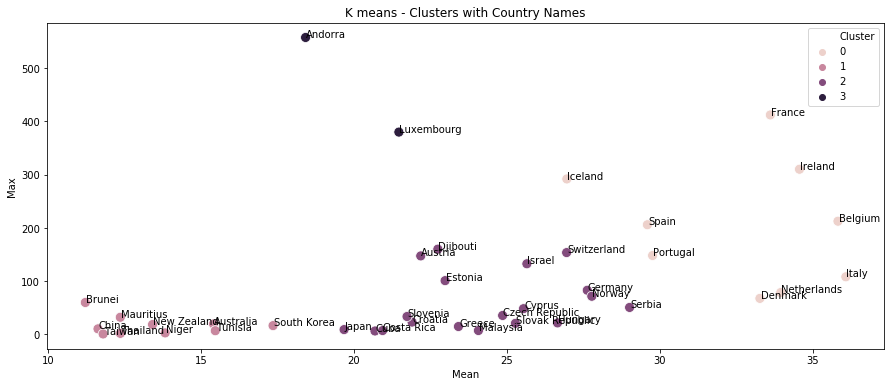

In [88]:
#Plot clusters
fig, ax = plt.subplots( 1, 1, figsize = ( 15, 6 ) )
g = sns.scatterplot( x = 'Mean', hue = 'Cluster', y = 'Max', data = df_kmeans, s= 100 )
g.set_title( 'K means - Clusters with Country Names' )

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(df_kmeans.Mean, df_kmeans.Max, df_kmeans.Countries, plt.gca()) 

In [89]:
#Merging the dataset to compare the Clusters vs Stringency Index
df_explo  = pd.read_csv('C:/Users/Milara/Desktop/Covid_data_HW5/dataset_surpressed_norm_days_may15th_v1.csv',encoding="ISO-8859-1")
df_kmeans = df_kmeans.rename(columns={"Countries": "Country"})

#Merging 
df_final= pd.merge(df_explo,
                  df_kmeans[['Country','Cluster']],
                  on = ['Country'],
                  how = 'left')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4560 entries, 0 to 4559
Data columns (total 16 columns):
Date                     4560 non-null object
Days                     4560 non-null int64
Country                  4560 non-null object
New_Cases_noNeg          4560 non-null int64
New Cases                4560 non-null int64
Confirmed                4560 non-null int64
Deaths                   4560 non-null int64
Recovered                4560 non-null int64
StringencyIndex          4560 non-null float64
Population (Millions)    4560 non-null float64
New Cases_norm           4560 non-null float64
Confirmed_norm           4560 non-null float64
Deaths_norm              4560 non-null float64
Recovered_norm           4560 non-null float64
New_Cases_noNeg_norm     4560 non-null float64
Cluster                  4560 non-null int64
dtypes: float64(7), int64(7), object(2)
memory usage: 605.6+ KB


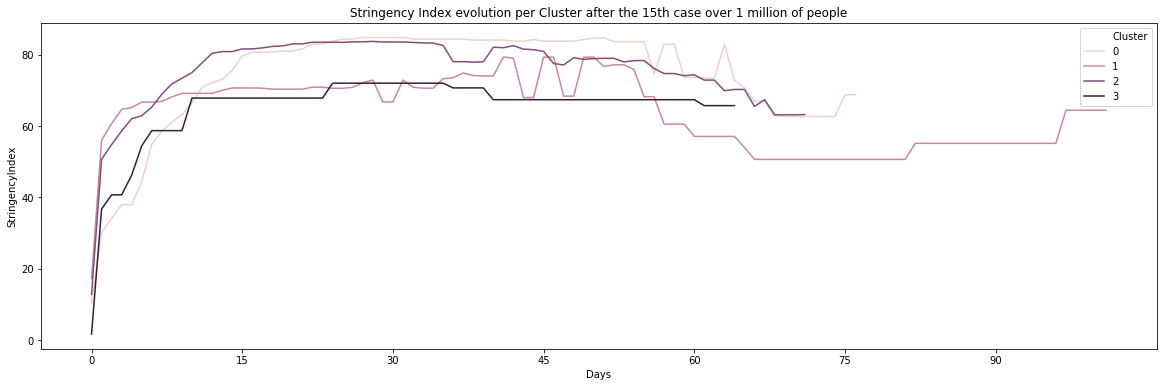

In [90]:
#Graph Stringency Index vs Clusters
fig, ax = plt.subplots( 1, 1, figsize = ( 20, 6 ) )
g = sns.lineplot( x = 'Days', hue = 'Cluster', y = 'StringencyIndex', data = df_final, ci= None )
g.set_title( 'Stringency Index evolution per Cluster after the 15th case over 1 million of people' )
plt.setp(ax,xticks=[0,15,30,45,60,75,90])


In [91]:
#Cluster 0
df_final['Country'][df_final['Cluster'] == 0].unique()

array(['France', 'Italy', 'Spain', 'Belgium', 'Ireland', 'Netherlands',
       'Portugal', 'Denmark', 'Iceland'], dtype=object)

In [92]:
#Cluster 1
df_final['Country'][df_final['Cluster'] == 1].unique()

array(['China', 'South Korea', 'Australia', 'Thailand', 'New Zealand',
       'Niger', 'Tunisia', 'Mauritius', 'Brunei', 'Taiwan'], dtype=object)

In [93]:
#Cluster 2
df_final['Country'][df_final['Cluster'] == 2].unique()

array(['Germany', 'Austria', 'Israel', 'Japan', 'Switzerland',
       'Czech Republic', 'Norway', 'Serbia', 'Djibouti', 'Estonia',
       'Greece', 'Hungary', 'Malaysia', 'Croatia', 'Cuba',
       'Slovak Republic', 'Slovenia', 'Costa Rica', 'Cyprus'],
      dtype=object)

In [94]:
#Cluster 3
df_final['Country'][df_final['Cluster'] == 3].unique()

array(['Luxembourg', 'Andorra'], dtype=object)

In [95]:
#Saving the file
df_final.to_csv("C:/Users/Milara/Desktop/HW5_ML/dataset_surpressed_norm_days_clusters_may15th_v1.csv", encoding="ISO-8859-1", index = False) #thus it is necessary to save it as the usual type of coding